In [1]:
library(ggplot2)
library(readr)
library(dplyr)
library(tidyr)
library(RColorBrewer)
library(viridis)
library(patchwork)
library(gridExtra)
library(grid)
library(sf)
library(dplyr)
library(purrr)
library(DBI)
library(RSQLite)
library(cowplot)
#conda install -c conda-forge r-cowplot


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: viridisLite


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Linking to GEOS 3.11.2, GDAL 3.7.0, PROJ 9.2.0; sf_use_s2() is TRUE


Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots




In [2]:
countries<-c(
    'BEN',
    'CMR',
    # 'COD',
    'COG',
    'CIV',
    'GNQ',
    'GIN',
    'GAB',
    'GMB',
    'GHA',
    'GNB',
    'LBR',
    # 'NGA',
    'SEN',
    'SLE',
    'TGO'
    )

In [3]:
base_dir<-"~/my-public-bucket/GEDI_global_PA_v2/WDPA_GEDI_extract"

In [ ]:
country<-"LBR"
file.path(base_dir, country,"WDPA_GEDI_extract")

In [8]:
# # Loop over countries
# for (country in countries) {
#   # Construct the path to the country folder
#   country_folder <- file.path(base_dir, country,"WDPA_GEDI_extract")
  
#   # Get full paths to all .gpkg files in the folder
#   gpkg_files <- list.files(path = country_folder, pattern = "\\.gpkg$", full.names = TRUE)
  
#   # Read and combine all .gpkg files for the country
#   combined_gpkg <- lapply(gpkg_files, st_read) %>%
#     bind_rows()
  
#   # Store combined dataframe 
#   clean_name <- paste(country)  # optional: clean the name
#   assign(clean_name, combined_gpkg)
    
#   # Write the combined data to a new GeoPackage in the same folder
#   output_path <- file.path(country_folder, paste0(clean_name, "_combined.gpkg"))
#   st_write(combined_gpkg, output_path, delete_layer = TRUE)
# }

In [4]:
# for (country in countries) {
#     country<- read_sf(paste("~/my-public-bucket/GEDI_global_PA_v2/WDPA_GEDI_extract/",country,
#                             "/WDPA_GEDI_extract/",country,"_combined.gpkg",sep=""))

#   }

In [7]:
#Write csvs summarizing all data
# Open the output file for writing directly
output_file <- "~/my-public-bucket/GEDI_global_PA_v2/WDPA_GEDI_extract/country_status_summary.csv"

# Create header row in output file (now with status and percentiles)
write_csv(
  data.frame(
    country = character(),
    status = integer(),
    count = integer(),
    rh98_mean = numeric(),
    rh98_p10 = numeric(),
    rh98_p90 = numeric(),
    rh100_mean = numeric(),
    rh100_p10 = numeric(),
    rh100_p90 = numeric(),
    pai_mean = numeric(),
    pai_p10 = numeric(),
    pai_p90 = numeric(),
    fhd_normal_mean = numeric(),
    fhd_normal_p10 = numeric(),
    fhd_normal_p90 = numeric()
  ),
  output_file
)

# Target columns for analysis
target_columns <- c("rh98", "rh100", "pai", "fhd_normal")

# Process each country and append results directly to the file
for (country in countries) {
  cat("Processing country:", country, "\n")
  
  # Direct path to the combined geopackage file
  file_path <- paste0("~/my-public-bucket/GEDI_global_PA_v2/WDPA_GEDI_extract/", country, 
                     "/WDPA_GEDI_extract/", country, "_combined.gpkg")
  
  # Skip if file doesn't exist
  if (!file.exists(file_path)) {
    cat("  File not found for", country, "\n")
    next
  }
  
  # Process the country with minimal memory usage
  tryCatch({
    # First, get layer info and find layer name
    layers <- st_layers(file_path)
    if (length(layers$name) == 0) {
      cat("  No layers in file for", country, "\n")
      next
    }
    
    # Get the first layer name
    layer_name <- layers$name[1]
    cat("  Using layer:", layer_name, "\n")
    
    # Build SQL query with the correct layer name
    query <- sprintf("SELECT status, %s FROM \"%s\"", 
                     paste(target_columns, collapse=", "), layer_name)
    
    # Read only the necessary columns to save memory
    country_data <- st_read(
      file_path, 
      query = query,
      quiet = TRUE
    ) %>% st_drop_geometry()
    
    # Skip if empty
    if (nrow(country_data) == 0) {
      cat("  No data for", country, "\n")
      next
    }
    
    # Process each status group separately
    status_values <- unique(country_data$status)
    
    for (status_val in status_values) {
      # Filter for current status
      status_data <- country_data[country_data$status == status_val, ]
      
      # Get count
      status_count <- nrow(status_data)
      
      if (status_count > 0) {
        # Create result row
        result_row <- data.frame(
          country = country,
          status = status_val,
          count = status_count
        )
        
        # Calculate statistics for each column
        for (col in target_columns) {
          # Only include rows without NA for this column
          valid_data <- status_data[[col]][!is.na(status_data[[col]])]
          
          if (length(valid_data) > 0) {
            # Calculate statistics
            result_row[[paste0(col, "_mean")]] <- mean(valid_data)
            result_row[[paste0(col, "_p10")]] <- quantile(valid_data, 0.1)
            result_row[[paste0(col, "_p90")]] <- quantile(valid_data, 0.9)
          } else {
            # Handle the case with no valid data
            result_row[[paste0(col, "_mean")]] <- NA
            result_row[[paste0(col, "_p10")]] <- NA
            result_row[[paste0(col, "_p90")]] <- NA
          }
        }
        
        # Append to output file
        write_csv(result_row, output_file, append = TRUE)
      }
      
      # Clear status_data to free memory
      rm(status_data)
      gc(verbose = FALSE)
    }
    
    # Clear country_data to free memory
    rm(country_data)
    gc(verbose = FALSE)
    
    cat("  Processed", sum(country_data$status %in% status_values), "records\n")
    
  }, error = function(e) {
    cat("  Error processing", country, ":", e$message, "\n")
  })
}

cat("\nCountry and status summary completed and saved to:", output_file, "\n")

# Optionally, create a separate country-level summary file too
country_summary_file <- "~/my-public-bucket/GEDI_global_PA_v2/WDPA_GEDI_extract/country_summary.csv"

cat("Reading status-level results to create country summary...\n")
if (file.exists(output_file)) {
  # Read the detailed results
  detailed_results <- read_csv(output_file)
  
  if (nrow(detailed_results) > 0) {
    # Create country-level summary
    country_summary <- detailed_results %>%
      group_by(country) %>%
      summarize(
        total_count = sum(count),
        avg_rh98 = weighted.mean(rh98_mean, count, na.rm = TRUE),
        avg_rh100 = weighted.mean(rh100_mean, count, na.rm = TRUE),
        avg_pai = weighted.mean(pai_mean, count, na.rm = TRUE),
        avg_fhd_normal = weighted.mean(fhd_normal_mean, count, na.rm = TRUE)
      )
    
    # Save the country summary
    write_csv(country_summary, country_summary_file)
    cat("Country-level summary saved to:", country_summary_file, "\n")
  } else {
    cat("No detailed results to create country summary from.\n")
  }
} else {
  cat("Detailed results file not found, skipping country summary.\n")
}

Processing country: BEN 
  Using layer: BEN_combined 
  Error processing BEN : object 'country_data' not found 
Processing country: CMR 
  Using layer: CMR_combined 
  Error processing CMR : object 'country_data' not found 
Processing country: COD 
  Using layer: COD_combined 
  Error processing COD : object 'country_data' not found 
Processing country: COG 
  Using layer: COG_combined 
  Error processing COG : object 'country_data' not found 
Processing country: CIV 
  Using layer: CIV_combined 
  Error processing CIV : object 'country_data' not found 
Processing country: GNQ 
  Using layer: GNQ_combined 
  Error processing GNQ : object 'country_data' not found 
Processing country: GIN 
  Using layer: GIN_combined 
  Error processing GIN : object 'country_data' not found 
Processing country: GAB 
  Using layer: GAB_combined 
  Error processing GAB : object 'country_data' not found 
Processing country: GMB 
  Using layer: GMB_combined 
  Error processing GMB : object 'country_data' not

Rows: 30 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): country
dbl (14): status, count, rh98_mean, rh98_p10, rh98_p90, rh100_mean, rh100_p1...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Country-level summary saved to: ~/my-public-bucket/GEDI_global_PA_v2/WDPA_GEDI_extract/country_summary.csv 


In [4]:
con <- dbConnect(SQLite(), "~/my-public-bucket/GEDI_global_PA_v2/WDPA_GEDI_extract/BEN/WDPA_GEDI_extract/BEN_combined.gpkg")
# Get the layer name if you're not sure
layers <- dbListTables(con)
# Read only the attribute data (no geometry)
BEN <- dbGetQuery(con, paste0("SELECT * FROM ", layers[1], " WHERE 1=1"))
dbDisconnect(con)

In [5]:
con <- dbConnect(SQLite(), "~/my-public-bucket/GEDI_global_PA_v2/WDPA_GEDI_extract/CMR/WDPA_GEDI_extract/CMR_combined.gpkg")
# Get the layer name if you're not sure
layers <- dbListTables(con)
# Read only the attribute data (no geometry)
CMR <- dbGetQuery(con, paste0("SELECT * FROM ", layers[1], " WHERE 1=1"))
dbDisconnect(con)

In [6]:
con <- dbConnect(SQLite(), "~/my-public-bucket/GEDI_global_PA_v2/WDPA_GEDI_extract/COG/WDPA_GEDI_extract/COG_combined.gpkg")
# Get the layer name if you're not sure
layers <- dbListTables(con)
# Read only the attribute data (no geometry)
COG <- dbGetQuery(con, paste0("SELECT * FROM ", layers[1], " WHERE 1=1"))
dbDisconnect(con)

In [ ]:
con <- dbConnect(SQLite(), "~/my-public-bucket/GEDI_global_PA_v2/WDPA_GEDI_extract/COD/WDPA_GEDI_extract/COD_combined.gpkg")
# Get the layer name if you're not sure
layers <- dbListTables(con)
# Read only the attribute data (no geometry)
COD <- dbGetQuery(con, paste0("SELECT * FROM ", layers[1], " WHERE 1=1"))
dbDisconnect(con)

In [7]:
con <- dbConnect(SQLite(), "~/my-public-bucket/GEDI_global_PA_v2/WDPA_GEDI_extract/CIV/WDPA_GEDI_extract/CIV_combined.gpkg")
# Get the layer name if you're not sure
layers <- dbListTables(con)
# Read only the attribute data (no geometry)
CIV <- dbGetQuery(con, paste0("SELECT * FROM ", layers[1], " WHERE 1=1"))
dbDisconnect(con)

In [8]:
con <- dbConnect(SQLite(), "~/my-public-bucket/GEDI_global_PA_v2/WDPA_GEDI_extract/GNQ/WDPA_GEDI_extract/GNQ_combined.gpkg")
# Get the layer name if you're not sure
layers <- dbListTables(con)
# Read only the attribute data (no geometry)
GNQ <- dbGetQuery(con, paste0("SELECT * FROM ", layers[1], " WHERE 1=1"))
dbDisconnect(con)

In [9]:
con <- dbConnect(SQLite(), "~/my-public-bucket/GEDI_global_PA_v2/WDPA_GEDI_extract/GIN/WDPA_GEDI_extract/GIN_combined.gpkg")
# Get the layer name if you're not sure
layers <- dbListTables(con)
# Read only the attribute data (no geometry)
GIN <- dbGetQuery(con, paste0("SELECT * FROM ", layers[1], " WHERE 1=1"))
dbDisconnect(con)

In [10]:
con <- dbConnect(SQLite(), "~/my-public-bucket/GEDI_global_PA_v2/WDPA_GEDI_extract/GAB/WDPA_GEDI_extract/GAB_combined.gpkg")
# Get the layer name if you're not sure
layers <- dbListTables(con)
# Read only the attribute data (no geometry)
GAB <- dbGetQuery(con, paste0("SELECT * FROM ", layers[1], " WHERE 1=1"))
dbDisconnect(con)

In [11]:
con <- dbConnect(SQLite(), "~/my-public-bucket/GEDI_global_PA_v2/WDPA_GEDI_extract/GHA/WDPA_GEDI_extract/GHA_combined.gpkg")
# Get the layer name if you're not sure
layers <- dbListTables(con)
# Read only the attribute data (no geometry)
GHA <- dbGetQuery(con, paste0("SELECT * FROM ", layers[1], " WHERE 1=1"))
dbDisconnect(con)

In [12]:
con <- dbConnect(SQLite(), "~/my-public-bucket/GEDI_global_PA_v2/WDPA_GEDI_extract/GMB/WDPA_GEDI_extract/GMB_combined.gpkg")
# Get the layer name if you're not sure
layers <- dbListTables(con)
# Read only the attribute data (no geometry)
GMB <- dbGetQuery(con, paste0("SELECT * FROM ", layers[1], " WHERE 1=1"))
dbDisconnect(con)

In [13]:
con <- dbConnect(SQLite(), "~/my-public-bucket/GEDI_global_PA_v2/WDPA_GEDI_extract/GNB/WDPA_GEDI_extract/GNB_combined.gpkg")
# Get the layer name if you're not sure
layers <- dbListTables(con)
# Read only the attribute data (no geometry)
GNB <- dbGetQuery(con, paste0("SELECT * FROM ", layers[1], " WHERE 1=1"))
dbDisconnect(con)

In [14]:
con <- dbConnect(SQLite(), "~/my-public-bucket/GEDI_global_PA_v2/WDPA_GEDI_extract/LBR/WDPA_GEDI_extract/LBR_combined.gpkg")
# Get the layer name if you're not sure
layers <- dbListTables(con)
# Read only the attribute data (no geometry)
LBR <- dbGetQuery(con, paste0("SELECT * FROM ", layers[1], " WHERE 1=1"))
dbDisconnect(con)

In [15]:
con <- dbConnect(SQLite(), "~/my-public-bucket/GEDI_global_PA_v2/WDPA_GEDI_extract/SLE/WDPA_GEDI_extract/SLE_combined.gpkg")
# Get the layer name if you're not sure
layers <- dbListTables(con)
# Read only the attribute data (no geometry)
SLE <- dbGetQuery(con, paste0("SELECT * FROM ", layers[1], " WHERE 1=1"))
dbDisconnect(con)

In [16]:
con <- dbConnect(SQLite(), "~/my-public-bucket/GEDI_global_PA_v2/WDPA_GEDI_extract/SEN/WDPA_GEDI_extract/SEN_combined.gpkg")
# Get the layer name if you're not sure
layers <- dbListTables(con)
# Read only the attribute data (no geometry)
SEN <- dbGetQuery(con, paste0("SELECT * FROM ", layers[1], " WHERE 1=1"))
dbDisconnect(con)

In [17]:
con <- dbConnect(SQLite(), "~/my-public-bucket/GEDI_global_PA_v2/WDPA_GEDI_extract/TGO/WDPA_GEDI_extract/TGO_combined.gpkg")
# Get the layer name if you're not sure
layers <- dbListTables(con)
# Read only the attribute data (no geometry)
TGO <- dbGetQuery(con, paste0("SELECT * FROM ", layers[1], " WHERE 1=1"))
dbDisconnect(con)

In [18]:
country_codes<-c(
    'BEN',
    'CMR',
    # 'COD',
    'COG',
    'CIV',
    'GNQ',
    'GIN',
    'GAB',
    'GMB',
    'GHA',
    'GNB',
    'LBR',
    # 'NGA',
    'SEN',
    'SLE',
    'TGO'
    )

In [126]:
# Function to create a set of plots for one country
create_country_plots <- function(country_data, country_name) {
  # Calculate the ratio
  country_data <- country_data %>%
    mutate(fhd_rh100_ratio = fhd_normal/rh100)
  
  # Plot 1: rh98
  plot1 <- ggplot(country_data, aes(x = rh98)) +
    geom_density(aes(group = as.factor(status), fill = as.factor(status)), alpha = 0.6, show.legend = FALSE) +
    geom_density(color = "red", size = 1, alpha = 1, lty = "dashed") +
    scale_fill_manual(values = c("0" = "purple", "1" = "pink"), 
                     labels = c("Non PA", "PA")) +
    theme_minimal() +
    labs(x = "Height", y = "Density", title = paste0(country_name, " - Height (rh98)")) +
    theme(legend.position = "none") +
    coord_flip() + 
    xlim(0, 45)
  
  # Plot 2: pai
  plot2 <- ggplot(country_data, aes(x = pai)) +
    geom_density(aes(group = as.factor(status), fill = as.factor(status)), alpha = 0.6, show.legend = FALSE) +
    geom_density(color = "red", size = 1, alpha = 1, lty = "dashed") +
    scale_fill_manual(values = c("0" = "purple", "1" = "pink"), 
                     labels = c("Non PA", "PA")) +
    theme_minimal() +
    labs(x = "PAI", y = "Density", title = paste0(country_name, " - PAI")) +
    theme(legend.position = "none") +
    coord_flip() + 
    xlim(0, 7)
  
  # Plot 3: fhd_normal
  plot3 <- ggplot(country_data, aes(x = fhd_normal)) +
    geom_density(aes(group = as.factor(status), fill = as.factor(status)), alpha = 0.6, show.legend = FALSE) +
    geom_density(color = "red", size = 1, alpha = 1, lty = "dashed") +
    scale_fill_manual(values = c("0" = "purple", "1" = "pink"), 
                     labels = c("Non PA", "PA")) +
    theme_minimal() +
    labs(x = "FHD", y = "Density", title = paste0(country_name, " - FHD")) +
    theme(legend.position = "none") +
    coord_flip() + 
    xlim(0, 3.5)
  
  # Plot 4: fhd_rh100_ratio
  plot4 <- ggplot(country_data, aes(x = fhd_rh100_ratio)) +
    geom_density(aes(group = as.factor(status), fill = as.factor(status)), alpha = 0.6, show.legend = FALSE) +
    geom_density(color = "red", size = 1, alpha = 1, lty = "dashed") +
    scale_fill_manual(values = c("0" = "purple", "1" = "pink"), 
                     labels = c("Non PA", "PA")) +
    theme_minimal() +
    labs(x = "FHD/RH100 Ratio", y = "Density", title = paste0(country_name, " - FHD/RH100")) +
    theme(legend.position = "none") +
    coord_flip() + 
    xlim(0, 1)
    
  # Return list of plots
  return(list(plot1 = plot1, plot2 = plot2, plot3 = plot3, plot4 = plot4))
}

# Process all countries
all_plots <- list()
for (country_code in country_codes) {
  # Get country data - this assumes the data is already loaded as variables named by country code
  if (exists(country_code)) {
    country_data <- get(country_code)
    country_plots <- create_country_plots(country_data, country_code)
    all_plots[[country_code]] <- country_plots
  } else {
    warning(paste("Data for", country_code, "not found"))
  }
}

[1] "Processing country: BEN"
[1] "Processing country: CMR"
[1] "Processing country: COG"
[1] "Processing country: CIV"
[1] "Processing country: GNQ"
[1] "Processing country: GIN"
[1] "Processing country: GAB"
[1] "Processing country: GMB"
[1] "Processing country: GHA"
[1] "Processing country: GNB"
[1] "Processing country: LBR"
[1] "Processing country: SEN"
[1] "Processing country: SLE"
[1] "Processing country: TGO"
[1] "Combined country plots created:"
[1] "patchwork"   "plot_filler" "gg"          "ggplot"     
[1] "Legend created"
[1] "Final plot assigned"
[1] "Annotation added"


Warning message:
“Removed 146 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 146 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 126 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 126 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_density()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_density()`).”
Warning message:
“Removed 47039 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 47039 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 15541 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 15541 rows containing non-finite outside the scale range

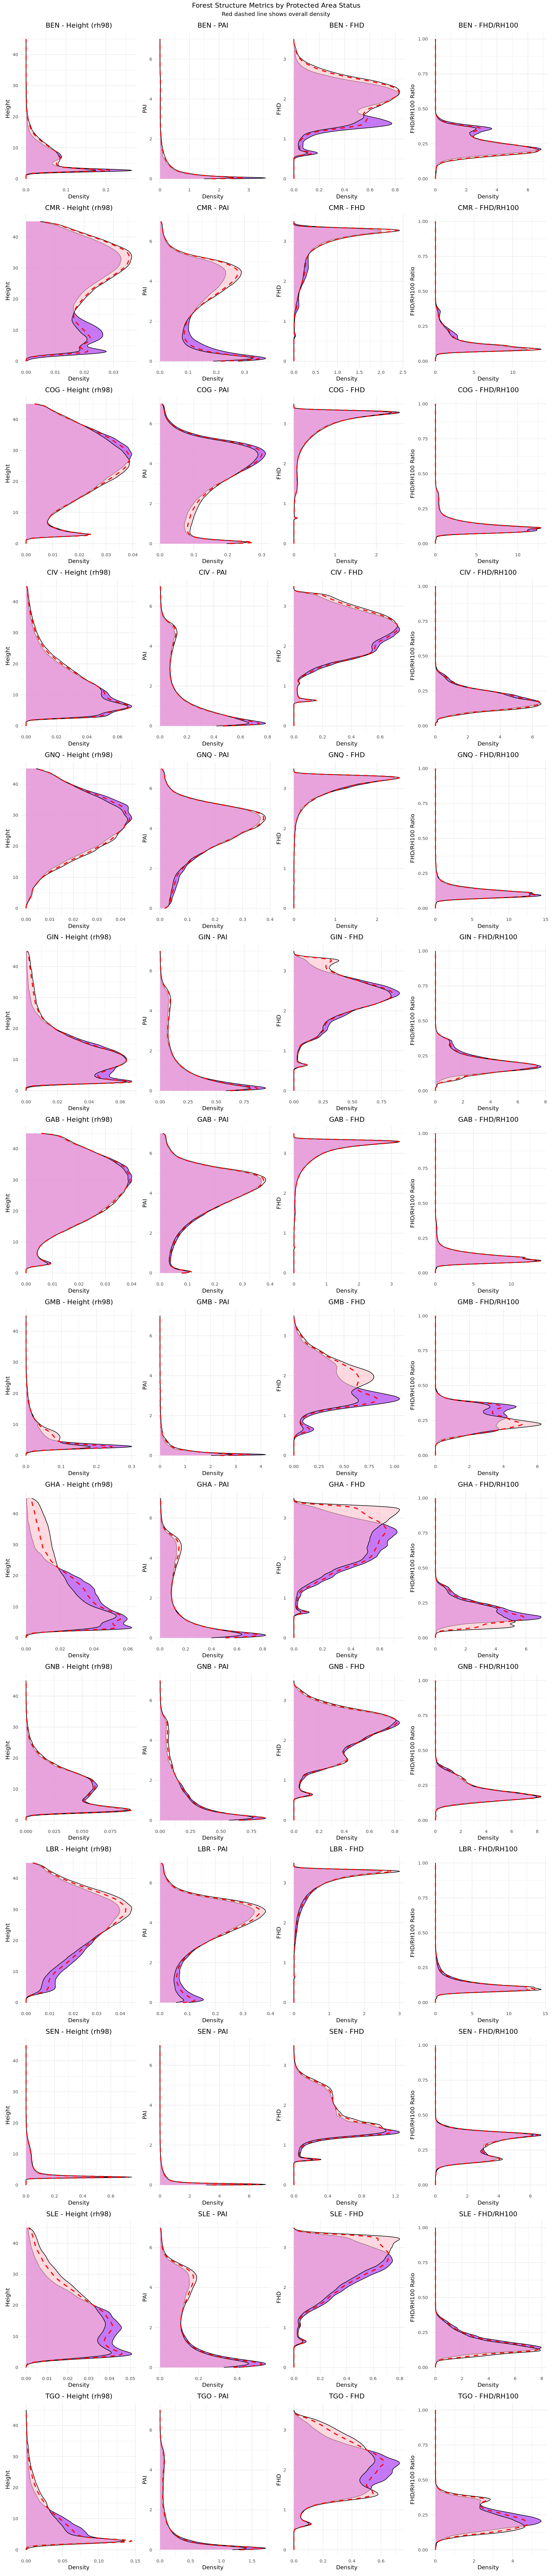

In [127]:
# First, let's create and check the combined country plots
combined_country_plots <- NULL

for (country_code in names(all_plots)) {
  country_plots <- all_plots[[country_code]]
  
  # Print what we're processing
  print(paste("Processing country:", country_code))
  
  # Create a row of plots for this country
  country_row <- country_plots$plot1 + country_plots$plot2 + 
                 country_plots$plot3 + country_plots$plot4 +
                 plot_layout(ncol = 4)
  
  # Add this row to the combined plot
  if (is.null(combined_country_plots)) {
    combined_country_plots <- country_row
  } else {
    combined_country_plots <- combined_country_plots / country_row
  }
}

# Check if combined_country_plots was created properly
print("Combined country plots created:")
print(class(combined_country_plots))

# Create the legend FIRST and check it
legend_plot <- ggplot(data.frame(x = 1:2, y = 1, status = c(0, 1)), 
                    aes(x = x, y = y, fill = as.factor(status))) +
  geom_col(show.legend = TRUE) +
  scale_fill_manual(name = "Status",
                    values = c("0" = "purple", "1" = "pink"),
                    labels = c("Non PA", "PA")) +
  theme_void() +
  theme(legend.position = "bottom")

# Extract legend with warning suppressed
legend <- suppressWarnings(cowplot::get_legend(legend_plot))
print("Legend created")

# Just check/display the combined plot with titles first
final_plot <- combined_country_plots
print("Final plot assigned")

# Add annotation
final_plot_with_annotation <- final_plot + 
  plot_annotation(
    title = "Forest Structure Metrics by Protected Area Status",
    subtitle = "Red dashed line shows overall density"
  ) &
  theme(plot.title = element_text(hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5))
print("Annotation added")

# Try displaying this intermediate result
print(final_plot_with_annotation)


In [128]:
# Save the plot if desired
ggsave("forest_metrics_by_country.png", final_plot_with_annotation, width = 10, height = 30, dpi = 300)

Warning message:
“Removed 146 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 146 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 126 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 126 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_density()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_density()`).”
Warning message:
“Removed 47039 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 47039 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 15541 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 15541 rows containing non-finite outside the scale range

Created plot for BEN

Created plot for CMR

Created plot for COG

Created plot for CIV

Created plot for GNQ

Created plot for GIN

Created plot for GAB

Created plot for GMB

Created plot for GHA

Created plot for GNB

Created plot for LBR

Created plot for SEN

Created plot for SLE

Created plot for TGO



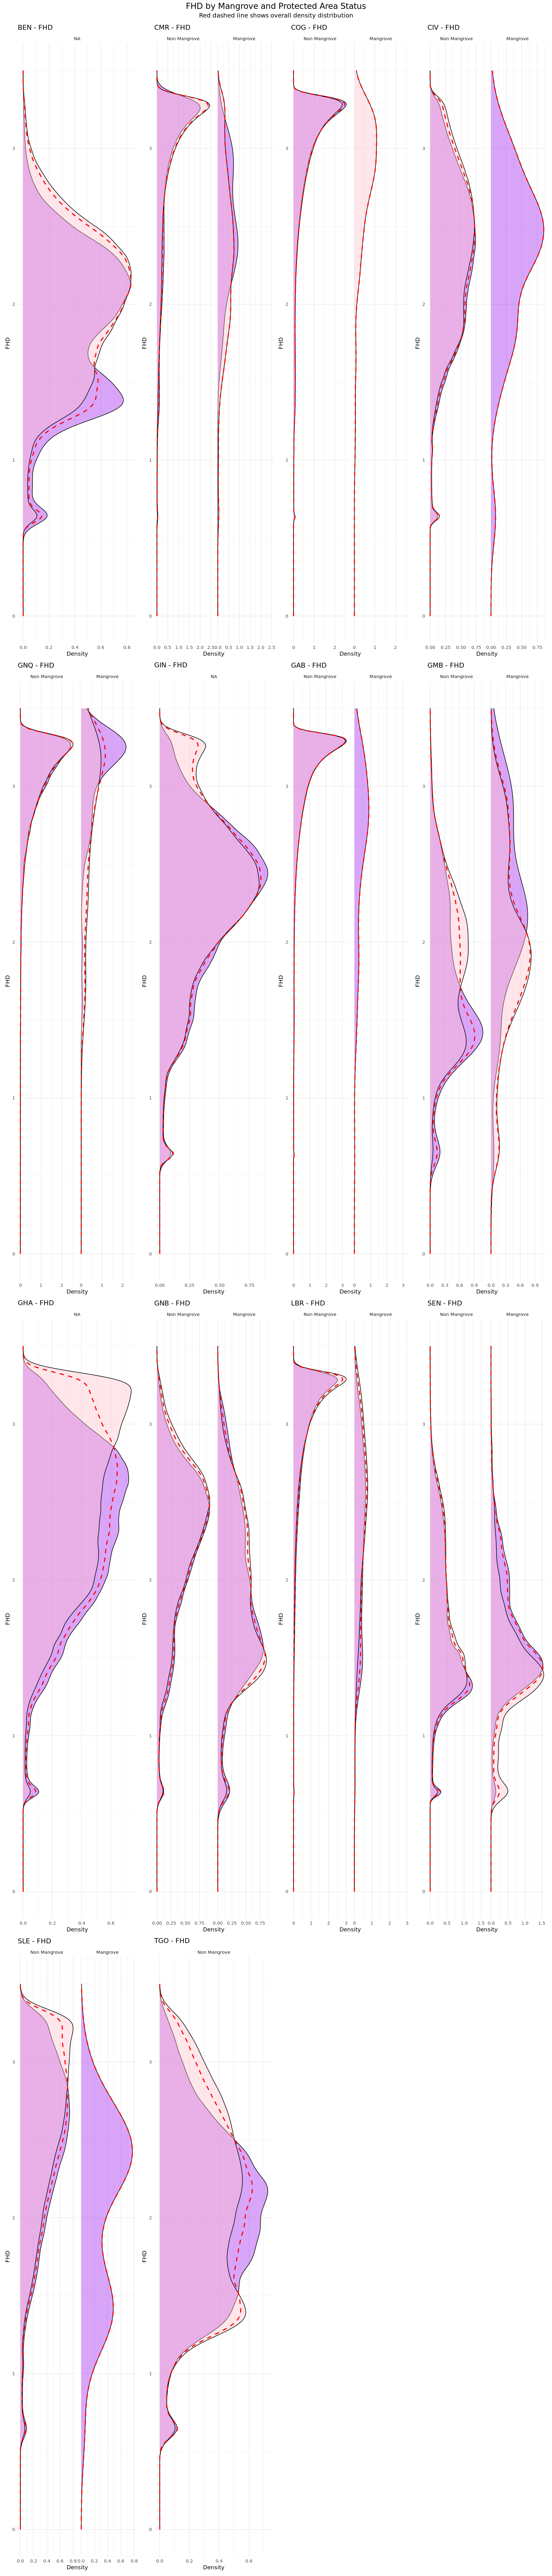

In [145]:
# Function to create FHD plots faceted by mangrove
create_fhd_rh100_plots <- function(country_codes) {
  # Initialize an empty list to store plots
  plots_list <- list()
  
  # Process each country
  for (country_code in country_codes) {
    # Check if the country data exists
    if (exists(country_code)) {
      # Get the country data
      country_data <- get(country_code)
      
      # Create the plot for this country
      plot <- ggplot(country_data, aes(x= fhd_normal)) + 
        geom_density(aes(fill=factor(status)), alpha=0.4, color = "black", show.legend = FALSE) +
        geom_density(color = "red", size = 1, alpha = 1, lty = "dashed") +
        scale_fill_manual(values = c("0" = "purple", "1" = "pink"), 
                          labels = c("Non PA", "PA")) +
        theme_minimal() +
        labs(x = "FHD", y = "Density", title = paste0(country_code, " - FHD")) +
        theme(legend.position = "none") +
        coord_flip() + 
        xlim(0, 3.5) +
        facet_wrap(~ mangrove, labeller = labeller(mangrove = c("0" = "Non Mangrove", 
                                                              "1" = "Mangrove")))
      
      # Add the plot to our list
      plots_list[[country_code]] <- plot
      
      # Print status
      message(paste("Created plot for", country_code))
    } else {
      warning(paste("Data for", country_code, "not found"))
    }
  }
  
  # Check if any plots were created
  if (length(plots_list) == 0) {
    stop("No plots created. Check your country_codes and data availability.")
  }
  
  # Determine grid layout based on number of plots
  n_plots <- length(plots_list)
  
  if (n_plots <= 3) {
    ncol <- n_plots  # One row if 3 or fewer plots
  } else if (n_plots <= 8) {
    ncol <- ceiling(n_plots/3)  # Two rows for 4-8 plots
  } else {
    ncol <- ceiling(n_plots/4)  # Three rows for more than 8 plots
  }
  
  # Combine all plots into a single figure
  combined_plot <- wrap_plots(plots_list, ncol = ncol)
  
  # Add a title and subtitle
  final_plot <- combined_plot +
    plot_annotation(
      title = "FHD by Mangrove and Protected Area Status",
      subtitle = "Red dashed line shows overall density distribution",
      theme = theme(
        plot.title = element_text(hjust = 0.5, size = 16),
        plot.subtitle = element_text(hjust = 0.5, size = 12)
      )
    )
  
  # MISSING LINE: Return the final plot
  return(final_plot)
}

plot_results <- create_fhd_rh100_plots(country_codes)

# Now display the result
print(plot_results)

In [148]:
# Save the plot if desired
ggsave("mangrove_metrics_by_country.png", plot_results, width = 10, height = 10, dpi = 300)

In [38]:
names(COG)

[1] "fid"               "geom"              "pa_id"            
  [4] "status"            "land_cover"        "mangrove"         
  [7] "shot_number"       "glad_change"       "glad_2020"        
 [10] "UID"               "fhd_normal"        "pai"              
 [13] "landsat_treecover" "rh20"              "rh70"             
 [16] "rh10"              "rh60"              "rh100"            
 [19] "rh90"              "rh50"              "rh40"             
 [22] "rh98"              "rh80"              "rh30"             
 [25] "rh25"              "rh75"              "cover_z0"         
 [28] "pai_z0"            "pavd_z0"           "cover_z1"         
 [31] "pai_z1"            "pavd_z1"           "cover_z2"         
 [34] "pai_z2"            "pavd_z2"           "cover_z3"         
 [37] "pai_z3"            "pavd_z3"           "cover_z4"         
 [40] "pai_z4"            "pavd_z4"           "cover_z5"         
 [43] "pai_z5"            "pavd_z5"           "cover_z6"         
 [46] "pai_z6"            "pavd_z6"           "cover_z7"         
 [49] "pai_z7"            "pavd_z7"           "cover_z8"         
 [52] "pai_z8"            "pavd_z8"           "cover_z9"         
 [55] "pai_z9"            "pavd_z9"           "cover_z10"        
 [58] "pai_z10"           "pavd_z10"          "cover_z11"        
 [61] "pai_z11"           "pavd_z11"          "cover_z12"        
 [64] "pai_z12"           "pavd_z12"          "cover_z13"        
 [67] "pai_z13"           "pavd_z13"          "cover_z14"        
 [70] "pai_z14"           "pavd_z14"          "cover_z15"        
 [73] "pai_z15"           "pavd_z15"          "cover_z16"        
 [76] "pai_z16"           "pavd_z16"          "cover_z17"        
 [79] "pai_z17"           "pavd_z17"          "cover_z18"        
 [82] "pai_z18"           "pavd_z18"          "cover_z19"        
 [85] "pai_z19"           "pavd_z19"          "cover_z20"        
 [88] "pai_z20"           "pavd_z20"          "cover_z21"        
 [91] "pai_z21"           "pavd_z21"          "cover_z22"        
 [94] "pai_z22"           "pavd_z22"          "cover_z23"        
 [97] "pai_z23"           "pavd_z23"          "cover_z24"        
[100] "pai_z24"           "pavd_z24"          "cover_z25"        
[103] "pai_z25"           "pavd_z25"          "cover_z26"        
[106] "pai_z26"           "pavd_z26"          "cover_z27"        
[109] "pai_z27"           "pavd_z27"          "cover_z28"        
[112] "pai_z28"           "pavd_z28"          "cover_z29"        
[115] "pai_z29"           "pavd_z29"

Created plot for BEN

Created plot for CMR

Created plot for COG

Created plot for CIV

Created plot for GNQ

Created plot for GIN

Created plot for GAB

Created plot for GMB

Created plot for GHA

Created plot for GNB

Created plot for LBR

Created plot for SEN

Created plot for SLE

Created plot for TGO

Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning mess

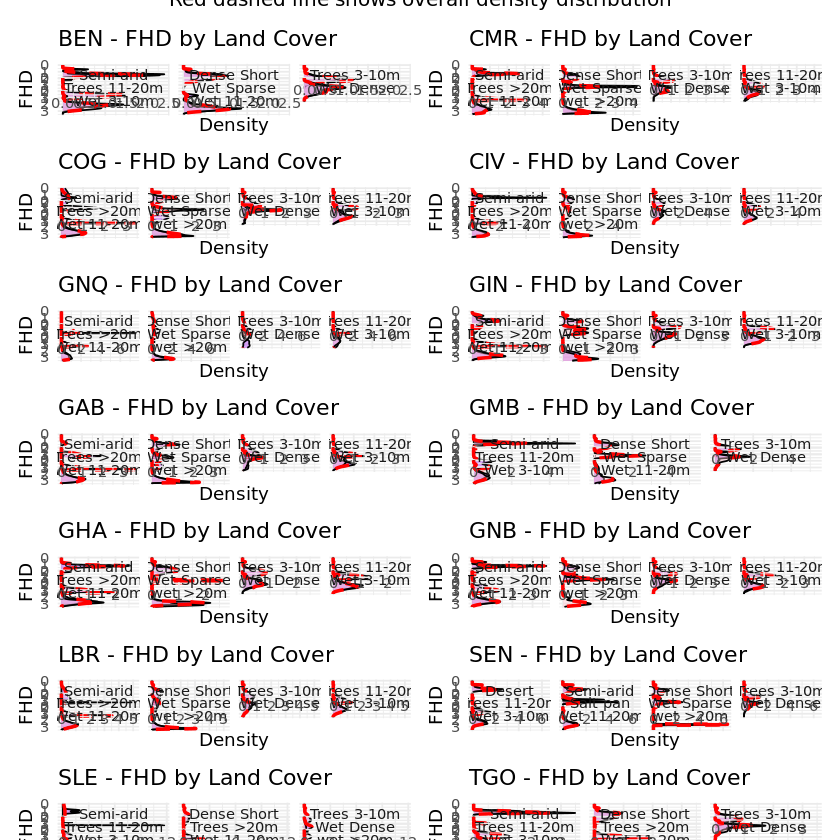

In [40]:
# Function to create FHD plots by land cover type
plot_fhd_by_landcover <- function(country_data, country_name, 
                                 landcover_list = c(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15)) {
  # Filter to only include the specified land cover types
  filtered_data <- country_data %>%  # FIXED: Use country_data not country_codes
    filter(glad_2020 %in% landcover_list)
  
  # Check if there's any data left after filtering
  if (nrow(filtered_data) == 0) {
    warning("No data matches the specified landcover types for ", country_name)
    return(NULL)
  }
  
  # Convert landcover to factor with appropriate labels
  landcover_labels <- c(
    "1" = "Desert", 
    "2" = "Semi-arid",
    "3" = "Dense Short",
    "4" = "Trees 3-10m",
    "5" = "Trees 11-20m",
    "6" = "Trees >20m",
    "7" = "Salt pan",
    "8" = "Wet Sparse",
    "9" = "Wet Dense",
    "10" = "Wet 3-10m",
    "11" = "Wet 11-20m",
    "12" = "wet >20m",
    "15" = "Cropland"
  )
  
  # Only keep labels for the land cover types in your filter
  landcover_labels <- landcover_labels[as.character(landcover_list)]
  
  # Create the plot
  plot <- ggplot(filtered_data, aes(x = fhd_normal)) + 
    geom_density(aes(fill = factor(status)), alpha = 0.4, color = "black", show.legend = FALSE) +
    geom_density(color = "red", size = 1, alpha = 1, lty = "dashed") +
    scale_fill_manual(values = c("0" = "purple", "1" = "pink"), 
                     labels = c("Non PA", "PA")) +
    theme_minimal() +
    labs(x = "FHD", y = "Density", title = paste0(country_name, " - FHD by Land Cover")) +
    theme(legend.position = "none") +
    coord_flip() + 
    xlim(0, 3.5) +
    facet_wrap(~ glad_2020, 
              labeller = labeller(glad_2020 = landcover_labels))
  
  return(plot)
}
  
# Example function for multiple countries 
plot_fhd_by_landcover_countries <- function(country_codes, 
                                           landcover_list = c(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15)) {
  # Initialize an empty list to store plots
  plots_list <- list()
  
  # Process each country
  for (country_code in country_codes) {
    # Check if the country data exists
    if (exists(country_code)) {
      # Get the country data
      country_data <- get(country_code)
      
      # Create the plot
      plot <- plot_fhd_by_landcover(country_data, country_code, landcover_list)
      
      # Add the plot to our list if it's not NULL
      if (!is.null(plot)) {
        plots_list[[country_code]] <- plot
        message(paste("Created plot for", country_code))
      }
    } else {
      warning(paste("Data for", country_code, "not found"))
    }
  }
  
  # Check if any plots were created
  if (length(plots_list) == 0) {
    stop("No plots created. Check your country_codes and data availability.")
  }
  
  # Combine all plots into a single figure
  combined_plot <- wrap_plots(plots_list, ncol = 2)  # Adjust ncol as needed
  
  # Add a title and subtitle
  final_plot <- combined_plot +
    plot_annotation(
      title = "FHD by Land Cover Type and Protected Area Status",
      subtitle = "Red dashed line shows overall density distribution",
      theme = theme(
        plot.title = element_text(hjust = 0.5, size = 16),
        plot.subtitle = element_text(hjust = 0.5, size = 12)
      )
    )
  
  return(final_plot)
}


# Now display the result
plot_landcover_results <- plot_fhd_by_landcover_countries(country_codes, landcover_list = c(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15))
print(plot_landcover_results)

In [42]:
# Save the plot if desired
ggsave("landcover_metrics_by_country.png", plot_landcover_results, width = 10, height = 30, dpi = 300)

Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to m

In [48]:
allPAs <- readRDS(paste("~/shared-buckets/leitoldv/GEDI_global_PA_v2/WDPA_shapefiles/WDPA_polygons/BEN_PA_poly.rds",sep=""))

In [51]:
names(allPAs)

[1] "WDPAID"     "WDPA_PID"   "PA_DEF"     "NAME"       "ORIG_NAME" 
 [6] "DESIG"      "DESIG_ENG"  "DESIG_TYPE" "IUCN_CAT"   "INT_CRIT"  
[11] "MARINE"     "REP_M_AREA" "GIS_M_AREA" "REP_AREA"   "GIS_AREA"  
[16] "NO_TAKE"    "NO_TK_AREA" "STATUS"     "STATUS_YR"  "GOV_TYPE"  
[21] "OWN_TYPE"   "MANG_AUTH"  "MANG_PLAN"  "VERIF"      "METADATAID"
[26] "SUB_LOC"    "PARENT_ISO" "ISO3"

In [57]:
allPAs$WDPA_PID

[1] 597   2252  2253  2254  5157  5158  5159  5160  5161  5162  6950  6951 
[13] 6952  6953  6954  6955  6956  7957  12201 19277 32995 32999 33005 33007
[25] 33010 33018 33019 33020
80238 Levels: 1 10 100 10000 100014 100017 100018 10002 100024 100037 ... 99998

In [19]:
add_designation_to_countries <- function(country_codes, rds_dir = "~/shared-buckets/leitoldv/GEDI_global_PA_v2/WDPA_shapefiles/WDPA_polygons") {
   # Process each country
  for (country_code in country_codes) {
    # Get country data (assuming it exists)
    country_data <- get(country_code)
    
    # Construct and read RDS file
    rds_path <- file.path(rds_dir, paste0(country_code, "_PA_poly.rds"))
    wdpa_data <- readRDS(rds_path)
    
    # Extract needed columns and convert to data frame if spatial
    if (inherits(wdpa_data, "SpatialPolygonsDataFrame")) {
      wdpa_subset <- as.data.frame(wdpa_data)
    } else {
      wdpa_subset <- wdpa_data
    }
    
    # Select needed columns and properly convert data types
    wdpa_subset <- wdpa_subset %>%
      select(WDPA_PID, DESIG_ENG) %>%
      # Convert WDPA_PID to character
      mutate(WDPA_PID = as.character(WDPA_PID),
             # Explicitly convert DESIG_ENG to character 
             DESIG_ENG = as.character(DESIG_ENG))
    
    # Perform the join
    country_data_updated <- country_data %>%
      mutate(pa_id = as.character(pa_id)) %>%
      left_join(wdpa_subset, by = c("pa_id" = "WDPA_PID"))
    
    # Create a completely new DESIG_TYPE column instead of modifying DESIG_ENG
    country_data_updated$DESIG_TYPE <- NA_character_  # Initialize with NA
    
    # Where DESIG_ENG exists, use it
    has_desig <- !is.na(country_data_updated$DESIG_ENG)
    if (any(has_desig)) {
      country_data_updated$DESIG_TYPE[has_desig] <- country_data_updated$DESIG_ENG[has_desig]
    }
    
    # For non-protected areas, use "Not Protected Area"
    non_pa <- !is.na(country_data_updated$status) & country_data_updated$status == 0
    if (any(non_pa)) {
      country_data_updated$DESIG_TYPE[non_pa] <- "Not Protected Area"
    }
    
    # Update in global environment
    assign(country_code, country_data_updated, envir = .GlobalEnv)
    
    # Simple status message
    message(paste("Updated", country_code))
  }
}

add_designation_to_countries(country_codes, rds_dir = "~/shared-buckets/leitoldv/GEDI_global_PA_v2/WDPA_shapefiles/WDPA_polygons")

Loading required package: sp

Updated BEN

Updated CMR

Updated COG

Updated CIV

Updated GNQ

Updated GIN

Updated GAB

Updated GMB

Updated GHA

Updated GNB

Updated LBR

Updated SEN

Updated SLE

Updated TGO



In [24]:
names(BEN)

[1] "fid"               "geom"              "pa_id"            
  [4] "status"            "land_cover"        "mangrove"         
  [7] "shot_number"       "glad_change"       "glad_2020"        
 [10] "UID"               "fhd_normal"        "pai"              
 [13] "landsat_treecover" "rh20"              "rh70"             
 [16] "rh10"              "rh60"              "rh100"            
 [19] "rh90"              "rh50"              "rh40"             
 [22] "rh98"              "rh80"              "rh30"             
 [25] "rh25"              "rh75"              "cover_z0"         
 [28] "pai_z0"            "pavd_z0"           "cover_z1"         
 [31] "pai_z1"            "pavd_z1"           "cover_z2"         
 [34] "pai_z2"            "pavd_z2"           "cover_z3"         
 [37] "pai_z3"            "pavd_z3"           "cover_z4"         
 [40] "pai_z4"            "pavd_z4"           "cover_z5"         
 [43] "pai_z5"            "pavd_z5"           "cover_z6"         
 [46] "pai_z6"            "pavd_z6"           "cover_z7"         
 [49] "pai_z7"            "pavd_z7"           "cover_z8"         
 [52] "pai_z8"            "pavd_z8"           "cover_z9"         
 [55] "pai_z9"            "pavd_z9"           "cover_z10"        
 [58] "pai_z10"           "pavd_z10"          "cover_z11"        
 [61] "pai_z11"           "pavd_z11"          "cover_z12"        
 [64] "pai_z12"           "pavd_z12"          "cover_z13"        
 [67] "pai_z13"           "pavd_z13"          "cover_z14"        
 [70] "pai_z14"           "pavd_z14"          "cover_z15"        
 [73] "pai_z15"           "pavd_z15"          "cover_z16"        
 [76] "pai_z16"           "pavd_z16"          "cover_z17"        
 [79] "pai_z17"           "pavd_z17"          "cover_z18"        
 [82] "pai_z18"           "pavd_z18"          "cover_z19"        
 [85] "pai_z19"           "pavd_z19"          "cover_z20"        
 [88] "pai_z20"           "pavd_z20"          "cover_z21"        
 [91] "pai_z21"           "pavd_z21"          "cover_z22"        
 [94] "pai_z22"           "pavd_z22"          "cover_z23"        
 [97] "pai_z23"           "pavd_z23"          "cover_z24"        
[100] "pai_z24"           "pavd_z24"          "cover_z25"        
[103] "pai_z25"           "pavd_z25"          "cover_z26"        
[106] "pai_z26"           "pavd_z26"          "cover_z27"        
[109] "pai_z27"           "pavd_z27"          "cover_z28"        
[112] "pai_z28"           "pavd_z28"          "cover_z29"        
[115] "pai_z29"           "pavd_z29"          "DESIG_ENG"        
[118] "DESIG_TYPE"

In [25]:
unique(BEN$DESIG_ENG)

[1] "National Park"     "Classified Forest" "Hunting Zone"

Created plot for BEN

Created plot for CMR

Created plot for COG

Created plot for CIV

Created plot for GNQ

Created plot for GIN

Created plot for GAB

Created plot for GMB

Created plot for GHA

Created plot for GNB

Created plot for LBR

Created plot for SEN

Created plot for SLE

Created plot for TGO



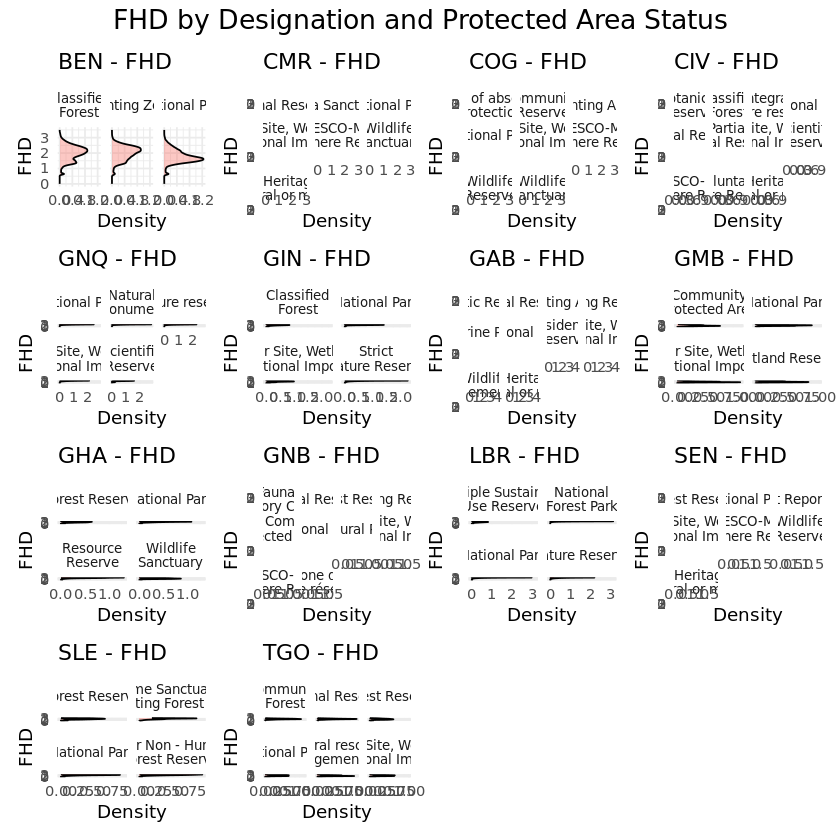

In [40]:
# Function to create FHD plots faceted by designation
create_fhd_plots <- function(country_codes, max_length = 15) {
  # Initialize plots list
  plots_list <- list()
  
  for (country_code in country_codes) {
    # Get country data
    country_data <- get(country_code)
    
    # Wrap long designation titles
    country_data$DESIG_WRAPPED <- sapply(country_data$DESIG_ENG, function(x) {
      label <- as.character(x)
      if (nchar(label) > max_length) {
        spaces <- gregexpr(" ", label)[[1]]
        if (length(spaces) > 0 && spaces[1] > 0) {
          mid_point <- floor(nchar(label) / 2)
          space_pos <- spaces[which.min(abs(spaces - mid_point))]
          return(paste0(substr(label, 1, space_pos-1), "\n", 
                       substr(label, space_pos+1, nchar(label))))
        }
      }
      return(label)
    })
    
    # Create the plot
    plot <- ggplot(country_data, aes(x = fhd_normal)) + 
      geom_density(aes(fill = "pink"), alpha = 0.4, show.legend = FALSE) +
      theme_minimal() +
      labs(x = "FHD", y = "Density", title = paste0(country_code, " - FHD")) +
      theme(
        legend.position = "none",
        strip.text = element_text(size = 8)
      ) +
      coord_flip() + 
      xlim(0, 3.5) +
      facet_wrap(~ DESIG_WRAPPED)
    
    # Add to list and show progress
    plots_list[[country_code]] <- plot
    message(paste("Created plot for", country_code))
  }
  
  # Determine layout
  n_plots <- length(plots_list)
  ncol <- if (n_plots <= 3) n_plots else if (n_plots <= 8) ceiling(n_plots/2) else ceiling(n_plots/4)
  
  # Combine plots
  final_plot <- wrap_plots(plots_list, ncol = ncol) +
    plot_annotation(
      title = "FHD by Designation and Protected Area Status",
      theme = theme(plot.title = element_text(hjust = 0.5, size = 16))
    )
  
  return(final_plot)
}

# Example usage
plot_results <- create_fhd_plots(country_codes)
print(plot_results)

In [41]:
# Save the plot if desired
ggsave("desigtype_metrics_by_country.png", plot_results, width = 20, height = 20, dpi = 300)

   country mean_fhd_nonpa mean_fhd_pa percent_diff
1      COG      3.4359174   3.3038004    -3.845174
2      GAB      3.9207131   3.9723067     1.315923
3      GNQ      3.8369045   3.9261595     2.326224
4      SEN      0.2514020   0.2616449     4.074322
5      LBR      3.5146777   3.8249574     8.828111
6      CIV      1.6187257   1.7748608     9.645555
7      CMR      2.7620788   3.1415950    13.740239
8      SLE      2.0808943   2.3887010    14.792040
9      GNB      1.2842541   1.4793814    15.193823
10     GIN      1.3087587   1.5239990    16.446145
11     GHA      1.8193633   2.1484518    18.088113
12     TGO      0.9623495   1.1386195    18.316631
13     BEN      0.4541266   0.5836641    28.524546
14     GMB      0.2960047   0.3905900    31.953982


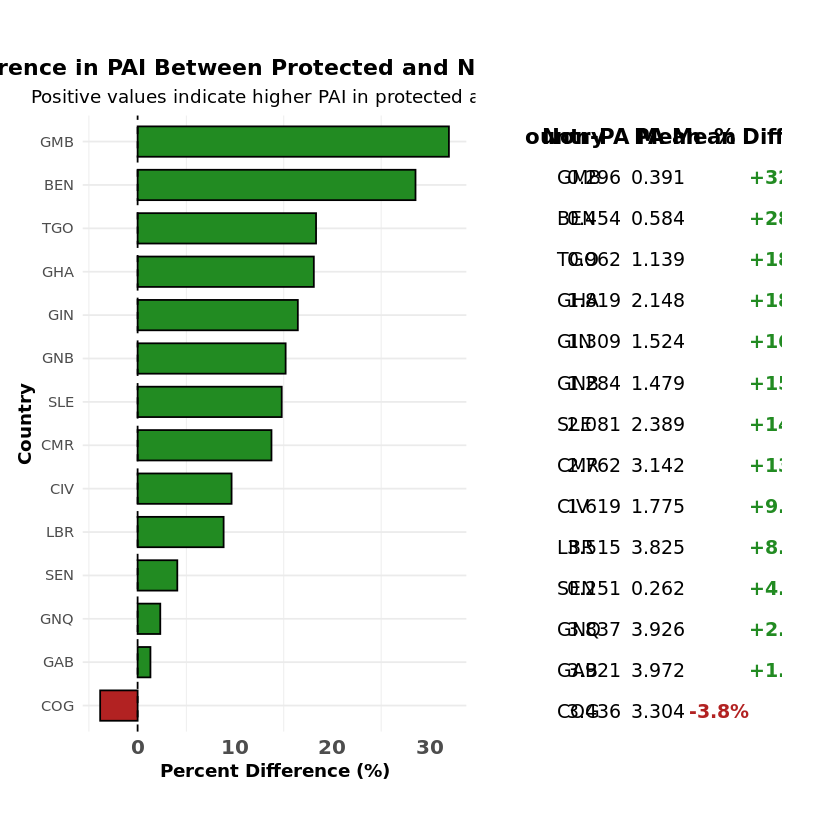

In [50]:
# Function to calculate and visualize % difference in FHD
visualize_fhd_percent_difference <- function(country_codes) {
  # Initialize dataframe to store results
  results_df <- data.frame(
    country = character(),
    mean_fhd_nonpa = numeric(),
    mean_fhd_pa = numeric(),
    percent_diff = numeric(),
    stringsAsFactors = FALSE
  )
  
  # Process each country
  for (country_code in country_codes) {
    # Check if the country data exists
    if (exists(country_code)) {
      # Get the country data
      country_data <- get(country_code)
      
      # Calculate mean FHD for protected and non-protected areas
      fhd_summary <- country_data %>%
        group_by(status) %>%
        summarize(mean_fhd = mean(pai, na.rm = TRUE))
      
      # Extract values
      if(nrow(fhd_summary) == 2) {
        mean_nonpa <- fhd_summary$mean_fhd[fhd_summary$status == 0]
        mean_pa <- fhd_summary$mean_fhd[fhd_summary$status == 1]
        
        # Calculate percentage difference: (PA - NonPA)/NonPA * 100
        percent_diff <- (mean_pa - mean_nonpa) / mean_nonpa * 100
        
        # Add to results dataframe
        results_df <- rbind(results_df, data.frame(
          country = country_code,
          mean_fhd_nonpa = mean_nonpa,
          mean_fhd_pa = mean_pa,
          percent_diff = percent_diff
        ))
      } else {
        warning(paste("Country", country_code, "does not have both protected and non-protected data"))
      }
    } else {
      warning(paste("Data for", country_code, "not found"))
    }
  }
  
  # Order countries by percent difference
  results_df <- results_df %>%
    arrange(percent_diff)
  
  # Add factor with ordered levels for plotting
  results_df$country <- factor(results_df$country, levels = results_df$country)
  
  # Create bar plot
  bar_plot <- ggplot(results_df, aes(x = country, y = percent_diff, fill = percent_diff > 0)) +
    geom_bar(stat = "identity", color = "black", width = 0.7) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
    scale_fill_manual(values = c("TRUE" = "forestgreen", "FALSE" = "firebrick"), 
                     guide = "none") +
    labs(
      title = "Percent Difference in PAI Between Protected and Non-Protected Areas",
      subtitle = "Positive values indicate higher PAI in protected areas",
      x = "Country",
      y = "Percent Difference (%)"
    ) +
    theme_minimal() +
    theme(
      axis.text.x = element_text(angle = 0, hjust = 0.5, face = "bold", size = 12),
      axis.title = element_text(face = "bold"),
      plot.title = element_text(hjust = 0.5, face = "bold"),
      plot.subtitle = element_text(hjust = 0.5),
      panel.grid.major.x = element_blank()
    ) +
    coord_flip()
  
  # Create a detailed table visualization
  table_data <- results_df %>%
    mutate(
      mean_fhd_nonpa = round(mean_fhd_nonpa, 3),
      mean_fhd_pa = round(mean_fhd_pa, 3),
      percent_diff = round(percent_diff, 1)
    )
  
  table_plot <- ggplot(table_data) +
    geom_text(aes(x = 1, y = seq_along(country), label = country), hjust = 0, size = 4) +
    geom_text(aes(x = 2, y = seq_along(country), label = mean_fhd_nonpa), hjust = 1, size = 4) +
    geom_text(aes(x = 3, y = seq_along(country), label = mean_fhd_pa), hjust = 1, size = 4) +
    geom_text(aes(x = 4, y = seq_along(country), 
                  label = paste0(ifelse(percent_diff > 0, "+", ""), percent_diff, "%"),
                  color = percent_diff > 0), 
              hjust = ifelse(table_data$percent_diff > 0, 0, 1),
              size = 4, fontface = "bold") +
    scale_color_manual(values = c("TRUE" = "forestgreen", "FALSE" = "firebrick"), guide = "none") +
    annotate("text", x = c(1, 2, 3, 4), y = length(table_data$country) + 1,
             label = c("Country", "Non-PA Mean", "PA Mean", "% Diff"),
             fontface = "bold", size = 4.5) +
    scale_x_continuous(limits = c(0.5, 4.5), expand = c(0, 0)) +
    scale_y_continuous(limits = c(0.5, length(table_data$country) + 1.5), expand = c(0, 0)) +
    theme_void() +
    theme(
      plot.margin = margin(30, 30, 30, 30),
      plot.background = element_rect(fill = "white", color = NA)
    )
  
  # Combine the plots
  combined_plot <- bar_plot + table_plot +
    plot_layout(widths = c(3, 2))
  
  return(list(
    plot = combined_plot,
    data = results_df
  ))
}

results <- visualize_fhd_percent_difference(country_codes)

# Display the plot
print(results$plot)

# Optionally, save the plot
# ggsave("fhd_percent_difference.png", results$plot, width = 12, height = 8, dpi = 300)

# You can also access the raw data
print(results$data)

In [51]:
# Save the plot if desired
ggsave("PAI_PercDifference.png", results$plot, width = 20, height = 20, dpi = 300)